# Name : Fernando I.A.M.D.
# Index No.: 190172K

In [2]:
import cv2
import numpy as np
import sympy
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from scipy . optimize import minimize
from scipy import linalg
from numpy.linalg import inv
from matplotlib.lines import Line2D
%matplotlib inline

## Q1

In [120]:
from math import sqrt
from scipy.stats import circstd

def dist(x1, y1, a, b, c):    
    d = abs((a * x1 + b * y1 + c)) / ((a * a + b * b)**0.5)
    return d

def findCircle(x1, y1, x2, y2, x3, y3) :
    c = (x1-x2)**2 + (y1-y2)**2
    a = (x2-x3)**2 + (y2-y3)**2
    b = (x3-x1)**2 + (y3-y1)**2
    s = 2*(a*b + b*c + c*a) - (a*a + b*b + c*c) 
    px = (a*(b+c-a)*x1 + b*(c+a-b)*x2 + c*(a+b-c)*x3) / s
    py = (a*(b+c-a)*y1 + b*(c+a-b)*y2 + c*(a+b-c)*y3) / s 
    ar = a**0.5
    br = b**0.5
    cr = c**0.5 
    r = ar*br*cr / ((ar+br+cr)*(-ar+br+cr)*(ar-br+cr)*(ar+br-cr))**0.5
    return (px, py), r


def ransacLine(x,y,N):
    Td =  1
    TiC = (N//2)*0.95
    print(TiC)

    iter = 10000
    max_in = 0
    model = (0,0)


    for i in range (iter):
        p = np.random.randint(0,len(y)) 
        q = np.random.randint(0,len(y))
        x1,x2,y1,y2 = x[p],x[q],y[p],y[q]
        if (x1!=x2):
            m1 = (y2 - y1) / (x2 - x1)
            c1 = y1 - m1 * x1 
            
        
            inl_cnt = 0
            for j in range(len(y)):
                a = dist(x[j],y[j],m1,-1,c1)
                if (a<=Td):
                    inl_cnt+=1
            # print(inl_cnt)
            if (inl_cnt>max_in and inl_cnt>TiC):
                max_in = inl_cnt
                model = (m1,c1)

    return model[0],model[1]

def ransacCircle(x,y,N):
    Td =  1
    TiC = 45 #(N//2)*0.95
    iter = 100
    short_list = []
    for i in range (iter):
        p = np.random.randint(0,len(y)) 
        q = np.random.randint(0,len(y))
        r = np.random.randint(0,len(y))
        x1,x2,x3,y1,y2,y3 = x[p],x[q],x[r],y[p],y[q],y[r]
        if (x1 != x2 and x2 != x3 and x1 != x3):
                cen,rad = findCircle(x1, y1, x2, y2, x3, y3)
                if (rad<10):
                    inl_cnt = 0
                    inl_x = []
                    inl_y = []
                    for j in range(len(y)):
                        dist = ((x[j] - cen[0])**2 + (y[j] - cen[1])**2)**0.5
                        if (abs(dist-rad)<Td):
                                inl_cnt+=1
                                inl_x.append(x[j])
                                inl_y.append(y[j])
                    if (inl_cnt>TiC):
                        for i in range (iter):
                            p = np.random.randint(0,len(inl_y)) 
                            q = np.random.randint(0,len(inl_y))
                            r = np.random.randint(0,len(inl_y))
                            x11,x22,x33,y11,y22,y33 = inl_x[p],inl_x[q],inl_x[r],inl_y[p],inl_y[q],inl_y[r]
                            if (x11 != x22 and x22 != x33 and x11 != x33):
                                    cen1,rad1 = findCircle(x11, y11, x22, y22, x33, y33)
                                    inl_x1 = []
                                    inl_y1 = []
                                    inl_cnt1 = 0
                                    error = 0
                                    for j in range(len(inl_y)):
                                        dist = ((inl_x[j] - cen1[0])**2 + (inl_y[j] - cen1[1])**2)**0.5
                                        if (abs(dist-rad1)<Td):
                                                error += abs(dist - rad1)
                                                inl_cnt1+=1
                                                inl_x1.append(inl_x[j])
                                                inl_y1.append(inl_y[j])
                                    if (inl_cnt>TiC):
                                        short_list.append([cen,rad,cen1,rad1,inl_cnt1,error/inl_cnt1,inl_x,inl_y,[x1,x2,x3],[y1,y2,y3]])
           
    short_list.sort(key=lambda x: (x[4],-x[5]))
    return short_list[-1]
    

23.75


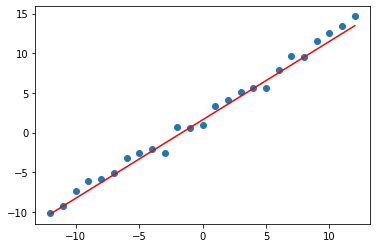

In [16]:
########## line ##############
N = 50
half_n = N//2
r = 10
s = r/16
x = np . linspace ( -12 , 12 , half_n )
m, b = 1, 2
y = m*x + b + s *np . random . randn ( half_n )
plt.scatter(x,y)

m1,c1 = ransacLine(x,y,N)

plt.plot(x,m1*x+c1,'r')
plt.show()

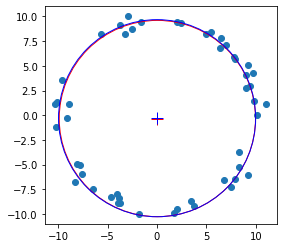

In [364]:
########## circle #############
N = 100
half_n = N//2
r = 10
s = r/16
t = np . random . uniform ( 0 , 2*np . pi , half_n )
n = s *np . random . randn ( half_n )
x , y = ( r + n ) * np . cos ( t ) , ( r + n ) * np . sin ( t )

z = ransacCircle(x,y,N)


figure, axes = plt.subplots()
plt.scatter(x,y)
aa = plt.Circle(z[0],z[1],fill=False,color='r')
axes.set_aspect( 1 )
axes.add_artist(aa )
plt.plot(z[0][0],z[0][1], 'r', marker='+', markersize=12)

bb = plt.Circle(z[2],z[3],fill=False,color='b')
axes.set_aspect( 1 )
axes.add_artist(bb )
plt.plot(z[2][0],z[2][1], 'b', marker='+', markersize=12)
plt.show()

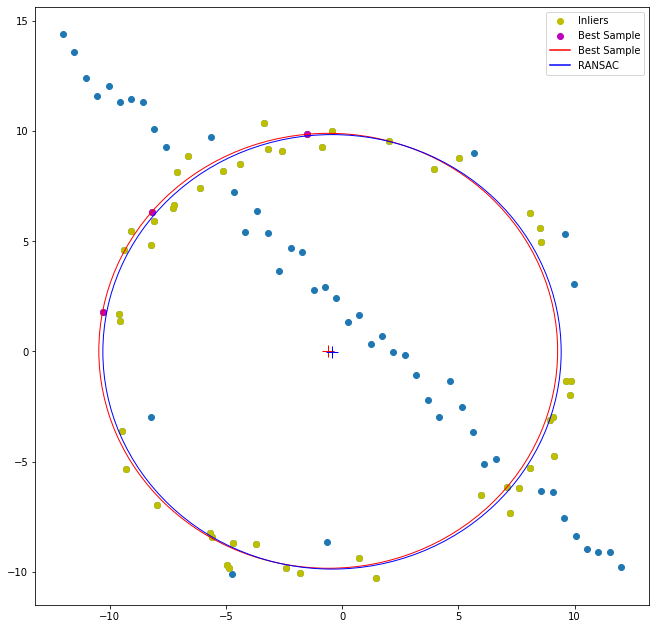

In [151]:
X_data, Y_data = [],[]
N = 100
half_n = N // 2
r = 10
s = r/16
t = np.random.uniform(0 , 2*np.pi , half_n )
n = s*np.random.randn(half_n)
x , y = (r+n)*np.cos(t),(r + n)*np.sin(t)
X_circ = np.hstack((x.reshape(half_n , 1 ) , y.reshape( half_n , 1 ) ) )
m, b = -1, 2
x = np.linspace(-12, 12 , half_n )
y = m*x + b + s*np.random.randn( half_n )
X_line = np.hstack((x.reshape( half_n , 1 ) , y.reshape( half_n , 1 ) ) )
X = np.vstack(( X_circ , X_line ) )

for vals in X:
    X_data.append(vals[0])
    Y_data.append(vals[1])


figure, axes = plt.subplots(figsize = (11,11))
plt.scatter(X_data,Y_data)
z = ransacCircle(X_data,Y_data,N)

aa = plt.Circle(z[0],z[1],fill=False,color='r')
axes.add_artist(aa)

plt.plot(z[0][0],z[0][1], 'r', marker='+', markersize=12)

bb = plt.Circle(z[2],z[3],fill=False,color='b')
axes.add_artist(bb)

plt.scatter(z[6],z[7],color = 'y',label = 'Inliers')
plt.scatter(z[8],z[9],color = 'm',label='Best Sample')

plt.plot(z[2][0],z[2][1], 'b', marker='+', markersize=12)

handles, labels = axes.get_legend_handles_labels()
legend =  [Line2D([0], [0], color='r', label='Best Sample',
                          markerfacecolor='g', markersize=10), Line2D([0], [0], color='b', label='RANSAC',
                          markerfacecolor='b', markersize=10)]
handles.append(legend[0])
handles.append(legend[1])

plt.legend(handles=handles)

plt.show()



## Q2

(84, 492, 3)


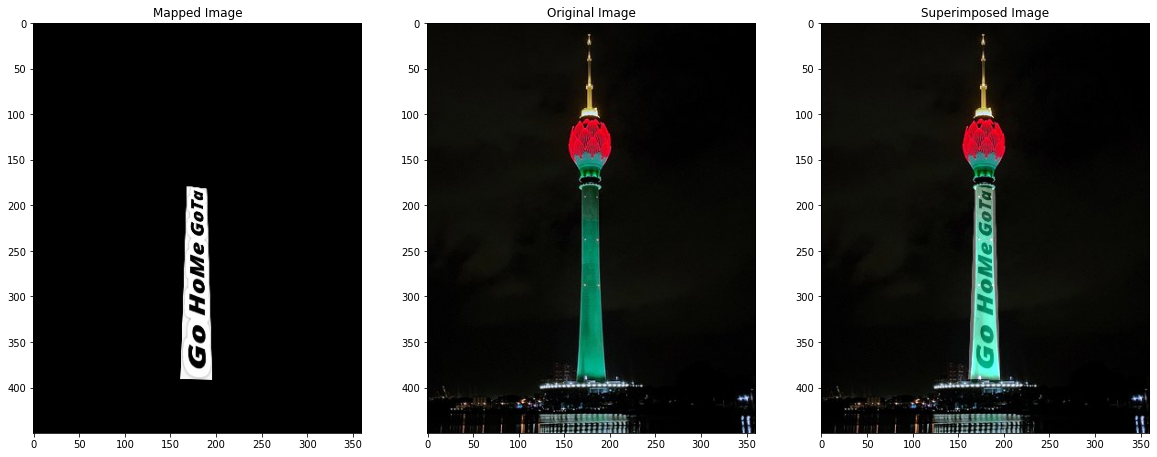

In [2]:
N = 4
global n
n = 0
pts_src = np.empty((N, 2))
pts_dst = np.empty((N, 2))

def draw_circle(event, x, y, flags, param):
    global n
    p = param[0]
    if event == cv2.EVENT_LBUTTONDOWN:
        cv2.circle(param[1], (x, y), 5, (255, 0, 0), -1)
        p[n] = (x, y)
        n += 1

im_src = cv2.imread('1.jpg')
print(im_src.shape)
pts_src = np.array([[0, 0], [0,im_src.shape[0]], [im_src.shape[1], 0],[im_src.shape[1], im_src.shape[0]]])

im_dst = cv2.imread('towering-at-an-imposing.jpg')

im_dst_copy = im_dst.copy()
param = [pts_dst, im_dst_copy]
cv2.namedWindow("Select Points", cv2.WINDOW_AUTOSIZE)
cv2.setMouseCallback('Select Points', draw_circle, param)

while (1):
    cv2.imshow("Select Points", im_dst_copy)
    if n == N:
        break
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
cv2.destroyAllWindows()
h, status = cv2.findHomography(pts_src, pts_dst)
im_out = cv2.warpPerspective(im_src, h, (im_dst.shape[1],im_dst.shape[0]))

im_out1 = cv2.addWeighted(im_dst,1,im_out,.4,0)

fig, ax = plt.subplots(1,3,figsize= (20,10))

ax[0].imshow(cv2.cvtColor(im_out, cv2.COLOR_BGR2RGB))
ax[0].set_title("Mapped Image")
ax[1].imshow(cv2.cvtColor(im_dst, cv2.COLOR_BGR2RGB))
ax[1].set_title("Original Image")
ax[2].imshow(cv2.cvtColor(im_out1, cv2.COLOR_BGR2RGB))
ax[2].set_title("Superimposed Image")
plt.show()

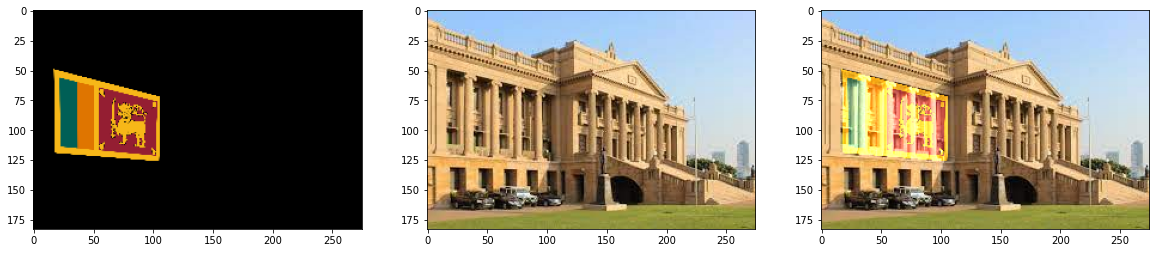

<Figure size 432x288 with 0 Axes>

In [156]:
N = 4
global n
n = 0
pts_src = np.empty((N, 2))
pts_dst = np.empty((N, 2))

def draw_circle(event, x, y, flags, param):
    global n
    p = param[0]
    if event == cv2.EVENT_LBUTTONDOWN:
        cv2.circle(param[1], (x, y), 5, (255, 0, 0), -1)
        p[n] = (x, y)
        n += 1

im_src = cv2.imread('Flag_of_Sri_Lanka.svg.png')
pts_src = np.array([[0, 0], [800,0], [0, 400],[800, 400]])

im_dst = cv2.imread('download.jpg')

im_dst_copy = im_dst.copy()
param = [pts_dst, im_dst_copy]
cv2.namedWindow("Select Points", cv2.WINDOW_AUTOSIZE)
cv2.setMouseCallback('Select Points', draw_circle, param)

while (1):
    cv2.imshow("Select Points", im_dst_copy)
    if n == N:
        
        break
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cv2.destroyAllWindows()
h, status = cv2.findHomography(pts_src, pts_dst)
im_out = cv2.warpPerspective(im_src, h, (im_dst.shape[1],im_dst.shape[0]))

im_out1 = cv2.addWeighted(im_dst,1,im_out,0.8,0)

fig, ax = plt.subplots(1,3,figsize= (20,10))

ax[0].imshow(cv2.cvtColor(im_out, cv2.COLOR_BGR2RGB))
ax[1].imshow(cv2.cvtColor(im_dst, cv2.COLOR_BGR2RGB))
ax[2].imshow(cv2.cvtColor(im_out1, cv2.COLOR_BGR2RGB))
plt.show()

## Q3

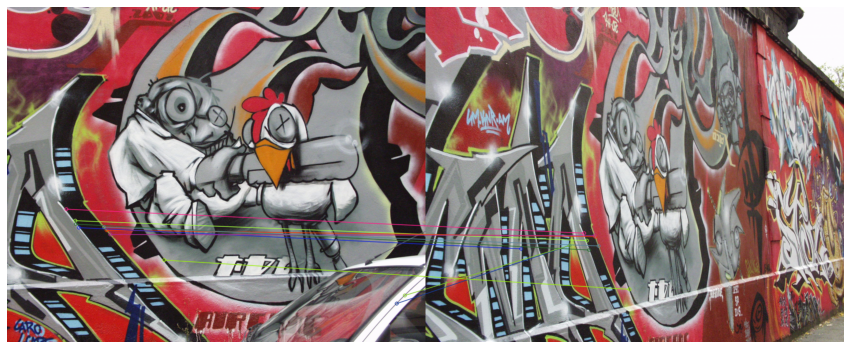

In [34]:
img1 = cv2.imread('img1.ppm')  
img2 = cv2.imread('img5.ppm') 

sift = cv2.SIFT_create(nOctaveLayers = 3,contrastThreshold = .1,edgeThreshold = 25,sigma = 1)

keypoints_1, descriptors_1 = sift.detectAndCompute(img1,None)
keypoints_2, descriptors_2 = sift.detectAndCompute(img2,None)

bf_match = cv2.BFMatcher(cv2.NORM_L1, crossCheck=True)

matches = bf_match.match(descriptors_1,descriptors_2)
matches = sorted(matches, key = lambda x:x.distance)

match_img = cv2.drawMatches(img1, keypoints_1, img2, keypoints_2, matches[:10], img2, flags=2)
plt.figure(figsize=(15,15))
plt.axis('off')
plt.imshow(cv2.cvtColor(match_img, cv2.COLOR_BGR2RGB))
plt.show()

In [36]:
def RansacHomo(sourcePoints,destinationPoints):
    iter = 500
    Td= 1
    maxInliers = []
    finalH = None
    for i in range(iter):
        p = np.random.randint(0,len(sourcePoints)) 
        q = np.random.randint(0,len(sourcePoints))
        r = np.random.randint(0,len(sourcePoints))
        s = np.random.randint(0,len(sourcePoints))
        
        P = [sourcePoints[p][0][0],sourcePoints[p][0][1],destinationPoints[p][0][0],destinationPoints[p][0][1]]
        Q = [sourcePoints[q][0][0],sourcePoints[q][0][1],destinationPoints[q][0][0],destinationPoints[q][0][1]]            
        x = np.vstack((P,Q))
        R = [sourcePoints[r][0][0],sourcePoints[r][0][1],destinationPoints[r][0][0],destinationPoints[r][0][1]]
        x = np.vstack((x,R))
        S = [sourcePoints[s][0][0],sourcePoints[s][0][1],destinationPoints[s][0][0],destinationPoints[s][0][1]]
        x = np.vstack((x,S))
        
        aList = []
        for corr in x:
            p1 = np.matrix([corr.item(0), corr.item(1), 1])
            p2 = np.matrix([corr.item(2), corr.item(3), 1])

            a2 = [0, 0, 0, -p2.item(2) * p1.item(0), -p2.item(2) * p1.item(1), -p2.item(2) * p1.item(2),
                p2.item(1) * p1.item(0), p2.item(1) * p1.item(1), p2.item(1) * p1.item(2)]
            a1 = [-p2.item(2) * p1.item(0), -p2.item(2) * p1.item(1), -p2.item(2) * p1.item(2), 0, 0, 0,
                p2.item(0) * p1.item(0), p2.item(0) * p1.item(1), p2.item(0) * p1.item(2)]
            aList.append(a1)
            aList.append(a2)

        matrixA = np.matrix(aList)

        u, s, v = np.linalg.svd(matrixA)

        H = np.reshape(v[8], (3, 3))
        H = (1/H.item(8)) * H
        inliers = []
        for k in range(len(sourcePoints)):
            
            d = geometricDistance([sourcePoints[k][0][0],sourcePoints[k][0][1],destinationPoints[k][0][0],destinationPoints[k][0][1]], H)
            if d < Td:
                inliers.append([sourcePoints[k][0][0],sourcePoints[k][0][1],destinationPoints[k][0][0],destinationPoints[k][0][1]])

        if len(inliers) > len(maxInliers):
            maxInliers = inliers
            finalH = H


    maxInliers1 = []
    finalH1 = None
    for i in range(iter):
            p = np.random.randint(0,len(maxInliers)) 
            q = np.random.randint(0,len(maxInliers))
            r = np.random.randint(0,len(maxInliers))
            s = np.random.randint(0,len(maxInliers))
            
            P = [maxInliers[p][0],maxInliers[p][1],maxInliers[p][2],maxInliers[p][3]]
            Q = [maxInliers[q][0],maxInliers[q][1],maxInliers[q][2],maxInliers[q][3]]            
            x = np.vstack((P,Q))
            R = [maxInliers[r][0],maxInliers[r][1],maxInliers[r][2],maxInliers[r][3]]
            x = np.vstack((x,R))
            S = [maxInliers[s][0],maxInliers[s][1],maxInliers[s][2],maxInliers[s][3]]
            x = np.vstack((x,S))

            aList = []
            for corr in x:
                p1 = np.matrix([corr.item(0), corr.item(1), 1])
                p2 = np.matrix([corr.item(2), corr.item(3), 1])

                a2 = [0, 0, 0, -p2.item(2) * p1.item(0), -p2.item(2) * p1.item(1), -p2.item(2) * p1.item(2),
                    p2.item(1) * p1.item(0), p2.item(1) * p1.item(1), p2.item(1) * p1.item(2)]
                a1 = [-p2.item(2) * p1.item(0), -p2.item(2) * p1.item(1), -p2.item(2) * p1.item(2), 0, 0, 0,
                    p2.item(0) * p1.item(0), p2.item(0) * p1.item(1), p2.item(0) * p1.item(2)]
                aList.append(a1)
                aList.append(a2)

            matrixA = np.matrix(aList)

            u, s, v = np.linalg.svd(matrixA)

            H = np.reshape(v[8], (3, 3))
            H = (1/H.item(8)) * H
            inliers = []
            for k in range(len(maxInliers)):
                
                d = geometricDistance([maxInliers[k][0],maxInliers[k][1],maxInliers[k][2],maxInliers[k][3]], H)
                if d < Td:
                    inliers.append([maxInliers[k][0],maxInliers[k][1],maxInliers[k][2],maxInliers[k][3]])
            
            if len(inliers) > len(maxInliers1):
                maxInliers1 = inliers
                finalH1 = H

    return maxInliers,finalH1

In [37]:
def homography(img1,img2):
    sift = cv2.SIFT_create(nOctaveLayers = 3,contrastThreshold = .1,edgeThreshold = 25,sigma =1)

    keyPoints1, descriptors1 = sift.detectAndCompute(img1, None)
    keyPoints2, descriptors2 = sift.detectAndCompute(img2, None)


    bf = cv2.BFMatcher()
    matches = bf.knnMatch(descriptors1, descriptors2, k=2)
    goodMatches = []
    for m, n in matches:
        if m.distance < 0.95 * n.distance:
            goodMatches.append(m)
    MIN_MATCH_COUNT = 10
    if len(goodMatches) > MIN_MATCH_COUNT:
        sourcePoints = np.float32([keyPoints1[m.queryIdx].pt for m in goodMatches]).reshape(-1, 1, 2)
        destinationPoints = np.float32([keyPoints2[m.trainIdx].pt for m in goodMatches]).reshape(-1, 1, 2)
        maxInliers1,finalH1 = RansacHomo(sourcePoints,destinationPoints)

    return finalH1

In [26]:
def geometricDistance(correspondence, h):

    p1 = np.transpose(np.matrix([correspondence[0], correspondence[1], 1]))
    estimatep2 = np.dot(h, p1)
    estimatep2 = (1/estimatep2.item(2))*estimatep2

    p2 = np.transpose(np.matrix([correspondence[2], correspondence[3], 1]))
    error = p2 - estimatep2
    return np.linalg.norm(error)


img1 = cv2.imread('img1.ppm')
img2 = cv2.imread('img2.ppm')
img3 = cv2.imread('img3.ppm')
img4 = cv2.imread('img4.ppm')
img5 = cv2.imread('img5.ppm')


H12 = homography(img1,img2)
H23 = homography(img2,img3)
H34 = homography(img3,img4)
H45 = homography(img4,img5)

H15 = H45 @ H34 @ H23 @ H12
print(H15)


[[ 6.25220453e-01  4.82833957e-02  2.20986126e+02]
 [ 2.23754319e-01  1.14698519e+00 -2.53684278e+01]
 [ 4.99804967e-04 -6.45730003e-05  9.94652753e-01]]


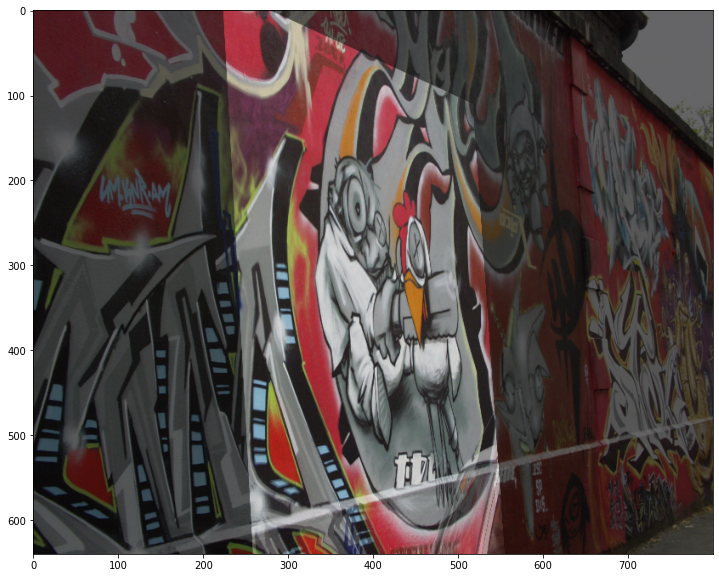

In [49]:
im1_warped = cv2.warpPerspective(img1, H15, (img5.shape[1],img5.shape[0]))
ret, threshold = cv2.threshold(im1_warped, 10, 1, cv2.THRESH_BINARY_INV)
img2_thresholded = np.multiply(threshold, img5)
img_blended = cv2.addWeighted(img2_thresholded, 1, im1_warped, 1, 0)

fig, ax = plt.subplots(1,4,figsize= (20,10))
ax[0].imshow(cv2.cvtColor(img1, cv2.COLOR_BGR2RGB))
ax[0].set_title("Image 1")
ax[1].imshow(cv2.cvtColor(img5, cv2.COLOR_BGR2RGB))
ax[1].set_title("Image 2")
ax[2].imshow(cv2.cvtColor(im1_warped, cv2.COLOR_BGR2RGB))
ax[2].set_title("Warped Image")
ax[3].imshow(cv2.cvtColor(img_blended, cv2.COLOR_BGR2RGB))
ax[3].set_title("Stiched Image")
plt.show()


In [38]:
H = homography(img1,img5)
print(H)

[[-9.99895408e-01 -5.45712234e-02  2.74966736e+02]
 [-1.65508524e+00 -9.03294743e-02  4.55140991e+02]
 [-3.63642317e-03 -1.98464819e-04  1.00000000e+00]]


In [40]:
correct = np.array([[6.2544644e-01  , 5.7759174e-02 ,  2.2201217e+02],
   [2.2240536e-01  , 1.1652147e+00 , -2.5605611e+01],
   [4.9212545e-04 ,-3.6542424e-05  , 1.0000000e+00]])
print(correct)

[[ 6.2544644e-01  5.7759174e-02  2.2201217e+02]
 [ 2.2240536e-01  1.1652147e+00 -2.5605611e+01]
 [ 4.9212545e-04 -3.6542424e-05  1.0000000e+00]]
